In [ ]:
import json
import numpy as np

firs = ""

with open('fir.json', 'r') as f:
    firs = json.load(f)

# for every entry check NAME and coordinates of FIR
for fir in firs['features']:
    name = "FIR"+fir['properties']['name']
    # extract all coordinates for
    coords = fir['geometry']['coordinates'][0]
    arr = np.array(coords)
    arr.T[[0,1]] = arr.T[[1,0]]
    c = np.round(arr.flatten(),4)
    print(' '.join(map(str,c)))
    print(name, end=' ')
    # print(np.array2string(c)[1 : -1])
    print(np.array2string(np.round(arr.flatten(),4))[1 : -1])

# print(json.dumps(firs, indent=4, sort_keys=True))

In [1]:
import rdp as RDP
import numpy as np

pos = np.array([
    [1,1], 
	[2,2],
	[3,3],
	[7,27],
	[10,10]
	])

anchors = [0, len(pos)-1]

RDP.simplify(pos, .1, anchors)

print(anchors)

[0, 2, 3, 4]


In [29]:
import rdp as RDP
import lzma
import pandas as pd
import numpy as np
from io import StringIO

n = 0
header = ""
oldId = ""
csv = ""

df_simple_01 = ""
df_simple_02 = ""
df_simple_03 = ""


with lzma.open("c:\\Users\\mschultz\\Downloads\\t_future_flas_360_ats_01.csv.xz", mode='rt', encoding='utf-8') as file:
    for line in file:
        id = line.split(sep=",")[0]
        if oldId != id:
            if(n > 1):  # ignore header
                print(header.split(sep=","))
                # print(csv)
                csvStringIO = StringIO(csv)
                df = pd.read_csv(csvStringIO, sep=",", header=None, names=header.split(sep=","))
                # print(df)
                pos = df[['latitude','longitude']].to_numpy()
                anchors = RDP.simplify(pos, .00001, [0, len(pos)-1])
                df_simple_01 = df.loc[anchors]
                anchors = RDP.simplify(pos, .1, [0, len(pos)-1])
                
                pos = df[['time','altitude']].to_numpy()
                anchors = RDP.simplify(pos, 50, anchors)
                df_simple_02 = df.loc[anchors]
                break
            elif(n == 0):
                # add header without \\\ at the end
                header = str(line[:-1])
            csv = ""
            n += 1
        csv += str(line)




        oldId = id


['id', 'time', 'altitude', 'longitude', 'latitude']


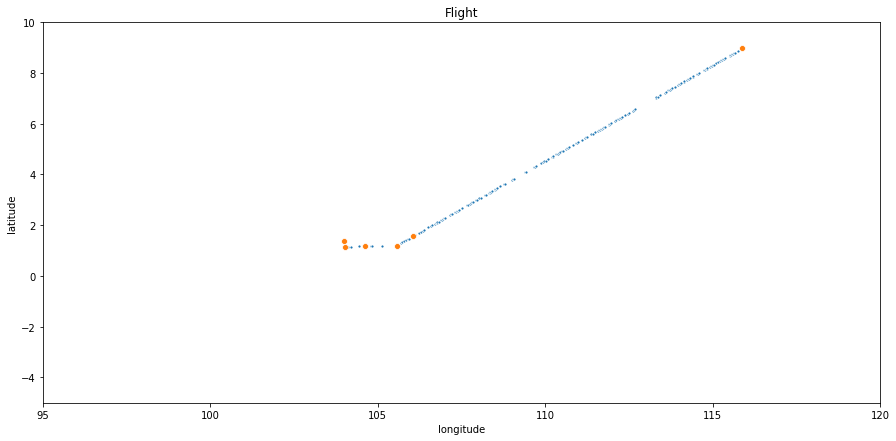

In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = '.',
    linestyle='',
    data=df_simple_01
).set_title('Flight')

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = 'o',
    linestyle='',
    data=df_simple_02
).set_title('Flight')

plt.xlim(95,120)
plt.ylim(-5,10)

plt.show()

In [31]:
df_simple_02

,id,time,altitude,longitude,latitude
0,SIA37A,-57081,0,-118.40778,33.94250
492,SIA37A,-56589,17401,-119.11849,34.27435
849,SIA37A,-56232,26144,-119.88633,34.62536
1476,SIA37A,-55605,35876,-121.39418,35.29218
1797,SIA37A,-55284,38377,-122.17051,35.62403
2206,SIA37A,-54875,40000,-123.16971,36.03983
50985,SIA37A,-6096,39982,115.88247,8.96816
56482,SIA37A,-599,39981,106.05093,1.56472
56754,SIA37A,-327,29798,105.57052,1.19662
57255,SIA37A,174,13893,104.62340,1.16765


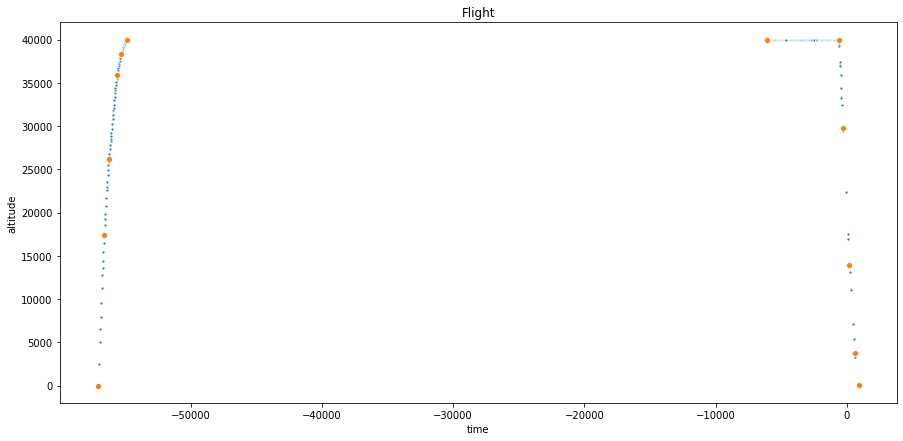

In [32]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = '.',
    linestyle='',
    data=df_simple_01
).set_title('Flight')

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = 'o',
    linestyle='',
    data=df_simple_02
).set_title('Flight')

# plt.xlim(95,120)
# plt.ylim(-5,10)

plt.show()

In [33]:
df_simple_02

# resample https://kanoki.org/2020/04/14/resample-and-interpolate-time-series-data/
# https://stackoverflow.com/questions/41854578/using-pandas-dataframe-interpolate-to-add-rows-to-dataframe#comment70893217_41854682


,id,time,altitude,longitude,latitude
0,SIA37A,-57081,0,-118.40778,33.94250
492,SIA37A,-56589,17401,-119.11849,34.27435
849,SIA37A,-56232,26144,-119.88633,34.62536
1476,SIA37A,-55605,35876,-121.39418,35.29218
1797,SIA37A,-55284,38377,-122.17051,35.62403
2206,SIA37A,-54875,40000,-123.16971,36.03983
50985,SIA37A,-6096,39982,115.88247,8.96816
56482,SIA37A,-599,39981,106.05093,1.56472
56754,SIA37A,-327,29798,105.57052,1.19662
57255,SIA37A,174,13893,104.62340,1.16765
